In [1]:
%reset -f
import sys
sys.path.append('/home/psimmerl/mds_analysis')

import pathlib

import math
import numpy as np
import numba as nb
from math import ceil, floor

from src.histo_utilities import std_color_list as SCL
# from src.helper_functions import alert, Table, weight_calc

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors


# **************************** #
LOCAL_DIR = '/home/psimmerl/mds_analysis'
OUT_DIR = f'{LOCAL_DIR}/reports/weekly/2024-04-15'

# **** #
MET_CATEGORY = ('lt200', 'low', 'high')[1]
TAG_CATEGORY = ('csccsc', 'cscdt')[1]
CUTSET = ('l1', 'scs', 'ropt', 'lopt')[3]
OOT = False#True

SIZE_VAR = TAG_CATEGORY[3:]

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# rt.gErrorIgnoreLevel = 1001  # rt.kInfo + 1
# rt.gROOT.SetBatch(True)
PI = rt.TMath.Pi()

# rt.EnableImplicitMT(4)
# print('Enabled ROOT\'s implicit multithreading (sometimes causes a crash)')

gc = []

# **************** #
print(f'{OOT=}')
print(f'{CUTSET=}')
print(f'{TAG_CATEGORY=}')
print(f'{MET_CATEGORY=}')
print('')

print(f'{OUT_DIR=}')
print('')



Welcome to JupyROOT 6.30/04
OOT=False
CUTSET='lopt'
TAG_CATEGORY='cscdt'
MET_CATEGORY='low'

OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-04-15'



   MIN_CSC_TIME =  -5.00 |    MAX_CSC_TIME =  12.50 | MAX_CSC_TSPREAD =  20.00 |      MAX_RPC_BX =   0.00 |    MIN_RPC_HITS =   1.00
    MAX_CSC_JET = 157.51 |      MAX_DT_JET =  81.31 |    MAX_CSC_MUON = 132.33 |     MAX_DT_MUON = 160.34 |         MAX_ME1 =   0.00
        MAX_MB1 =   0.36 |     HALO_CUTOFF =   0.04 |        MIN_DPHI =   0.56 |        MIN_DETA =   0.09 |        MAX_DETA =   2.98
    MIN_CSC_DNN =   0.00 |      MIN_DT_DNN =   0.00 |     MIN_DT_SIZE =  97.90 | 

97.90272184191807

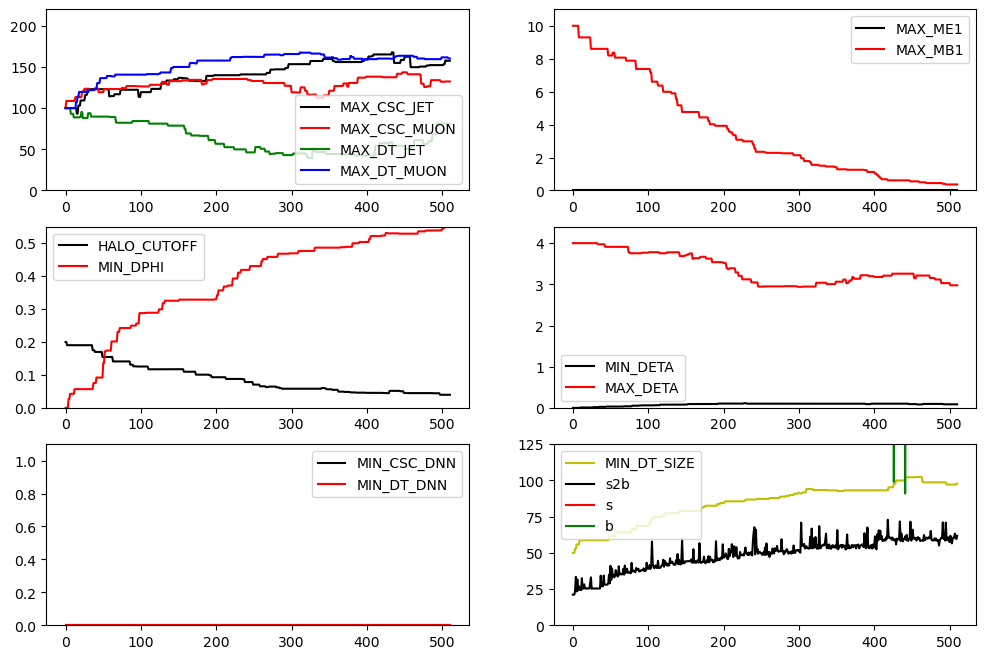

In [56]:
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt

# ******************************** #
# with open(f'{LOCAL_DIR}/loo_scores_cscdt_lopt_low.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/loo_scores_cscdtOOT_lopt_high.pkl', 'rb') as f:
with open(f'{LOCAL_DIR}/loo_scores_cscdtOOT_lopt_lt200.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/loo_scores_cscdtOOT_lopt_low.pkl', 'rb') as f:
# with open(f'{LOCAL_DIR}/loo_scores_cscdtOOT_lopt_high.pkl', 'rb') as f:
    loo = pickle.load(f)

cut_names = list(loo[-1][-1].keys())
cuts = np.array([[l[-1][k] for k in cut_names] for l in loo])
s2b = np.array([l[2] for l in loo])
s = np.array([l[3] for l in loo])
b = np.array([l[4] for l in loo])

f, grid = plt.subplots(3,2,figsize=(12,8))

t = np.arange(len(cuts))

grid[0,0].plot(t, cuts[:,5], 'k', label=cut_names[5])
grid[0,0].plot(t, cuts[:,7], 'r', label=cut_names[7])
grid[0,0].plot(t, cuts[:,6], 'g', label=cut_names[6])
grid[0,0].plot(t, cuts[:,8], 'b', label=cut_names[8])
grid[0,0].legend()
grid[0,0].set_ylim(0, 200*1.1)

grid[0,1].plot(t, cuts[:,9], 'k', label=cut_names[9])
grid[0,1].plot(t, cuts[:,10], 'r', label=cut_names[10])
grid[0,1].legend()
grid[0,1].set_ylim(0,10*1.1)

grid[1,0].plot(t, cuts[:,11], 'k', label=cut_names[11])
grid[1,0].plot(t, cuts[:,12], 'r', label=cut_names[12])
grid[1,0].legend()
grid[1,0].set_ylim(0, 0.5*1.1)

grid[1,1].plot(t, cuts[:,13], 'k', label=cut_names[13])
grid[1,1].plot(t, cuts[:,14], 'r', label=cut_names[14])
grid[1,1].legend()
grid[1,1].set_ylim(0, 4*1.1)

grid[2,0].plot(t, cuts[:,15], 'k', label=cut_names[15])
grid[2,0].plot(t, cuts[:,16], 'r', label=cut_names[16])
grid[2,0].legend()
grid[2,0].set_ylim(0, 1*1.1)


grid[2,1].plot(t, cuts[:,17], 'y', label=cut_names[17])
grid[2,1].plot(t, s2b, 'k', label='s2b')
grid[2,1].plot(t, s, 'r', label='s')
grid[2,1].plot(t, b, 'g', label='b')
grid[2,1].legend()
grid[2,1].set_ylim(0, max(cuts[:17].max(),s2b.max())*1.1)
# grid[2,1].set_ylim(0, s2b.max()*1.1)
# grid[2,1].set_ylim(0, 1000*1.1)

adj = max([len(k) for k in cut_names])
icol = 0
for k, v in loo[-1][-1].items():
    icol+=1
    print(f'{k:>{adj}} = {v:6.2f}',end=' | ' if icol%5 else '\n')
cuts[-1,-1]

In [51]:
#   1 |      min dPhi =   0.46 (  0.00) |  31 ( 17),   1762 (  1766),   3135 ( 10777)
# (0.46*1762/(5*(1-1/5001)) + 0.00*1766)/(1762/(5*(1-1/5001)) + 1766)
(1762/(5*(1-1/5001)))/(1762/(5*(1-1/5001)) + 1766)
# ( (1/10)/(1+1/10) ) / ( 1/(1+1/10) ), ( (1/20)/(1+1/20) ) / ( 1/(1+1/20) ), ( (1/50)/(1+1/50) ) / ( 1/(1+1/50) )
( (1/10)/(1+1/10) ) , ( (1/20)/(1+1/20) ) , ( (1/50)/(1+1/50) ) 

(0.09090909090909091, 0.047619047619047616, 0.0196078431372549)